In [1]:
%load_ext autoreload

In [18]:
%autoreload 2

import functools

from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as met

from tomo2seg.data import volume_precipitates_dryrun as volume_paths, ModelPaths
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz

In [19]:
dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
_hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

hst_read = lambda x: _hst_read(str(x))

labels_list = [0, 1, 2]

class labels:
    matrix = 0
    fiber = 1
    hole = 2

In [20]:
val = VolumeImgSegmSequence(
    # get a 3d np array
    source_volume=hst_read(volume_paths.val_data_path),  
    label_volume=hst_read(volume_paths.val_labels_path),  
    labels=labels_list,  # the classes encodings
    axes=(2,),  # z-axis slices only
    batch_size=1,
    shuffle=False, 
    normalization_const=255,
    n_geometric_augmentations=0,  # only the original slices as is
#     crop_size=500,  # no crop, get the whole slice
    crop_size=224,  
)

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


In [21]:
val_volume = hst_read(volume_paths.val_data_path)
val_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

# Reference segmentation

## Train volume


## Validation volume

# Model

# Predict

## Train

In [22]:
train_pred = np.load("train-pred-classes.npy")

In [23]:
[val.slice_params[id_] for id_ in range(4)]

[_SliceParams(axis=2, coordinate=0, corner=<_Corner.BL: 0>, geometric_transformation=<GT.identity: 0>),
 _SliceParams(axis=2, coordinate=0, corner=<_Corner.BR: 1>, geometric_transformation=<GT.identity: 0>),
 _SliceParams(axis=2, coordinate=0, corner=<_Corner.UL: 2>, geometric_transformation=<GT.identity: 0>),
 _SliceParams(axis=2, coordinate=0, corner=<_Corner.UR: 3>, geometric_transformation=<GT.identity: 0>)]

In [24]:
from tomo2seg import volume_img_segm

In [25]:
corners = list(volume_img_segm._Corner)
assert tuple(c.value for c in corners) == (0, 1, 2, 3)

In [26]:
for corn, crop in zip(
    [
        volume_img_segm._Corner.UL,
        volume_img_segm._Corner.UR,
        volume_img_segm._Corner.BL,
        volume_img_segm._Corner.BR,
    ],
    [
        val_volume[:224, :224, 0],
        val_volume[-224:, :224, 0],
        val_volume[:224, -224:, 0],
        val_volume[-224:, -224:, 0],
    ],
):
    one_slice_param = volume_img_segm._SliceParams(
        axis=2, 
        coordinate=0, 
        corner=corn, 
        geometric_transformation=volume_img_segm.GT.identity
    )
    X, y = volume_img_segm._generate_one_slice(
        source_volume=val_volume,
        label_volume=np.zeros_like(val_volume),
        crop_size=224,
        labels=[0, 1, 2],
        slice_param=one_slice_param,
    )
    assert all((X == crop).ravel()), f"{corn}"

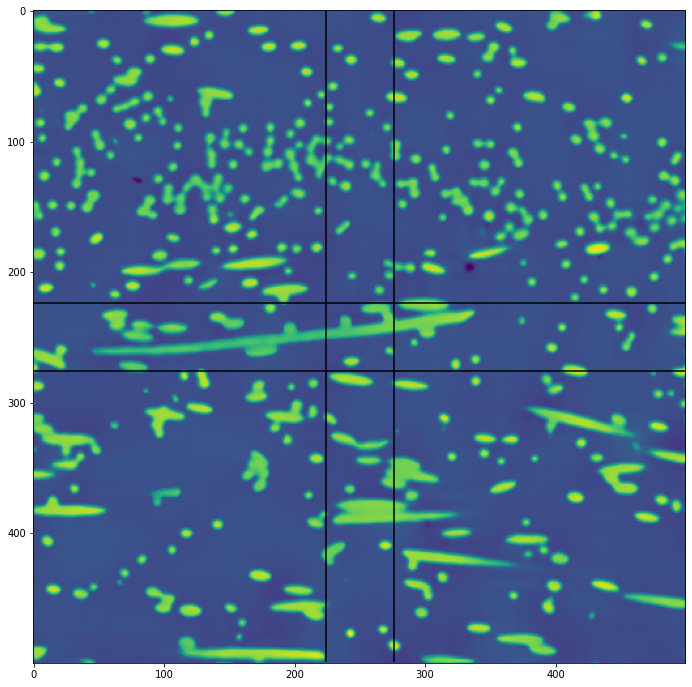

In [27]:
gen = val
sz=12
plt.figure(figsize=(sz, sz))
plt.imshow(gen.source_volume[:, :, 0])
plt.vlines([224, 500 - 224], 0, 500 -1, color='k')
plt.hlines([224, 500 - 224], 0, 500 -1, color='k')

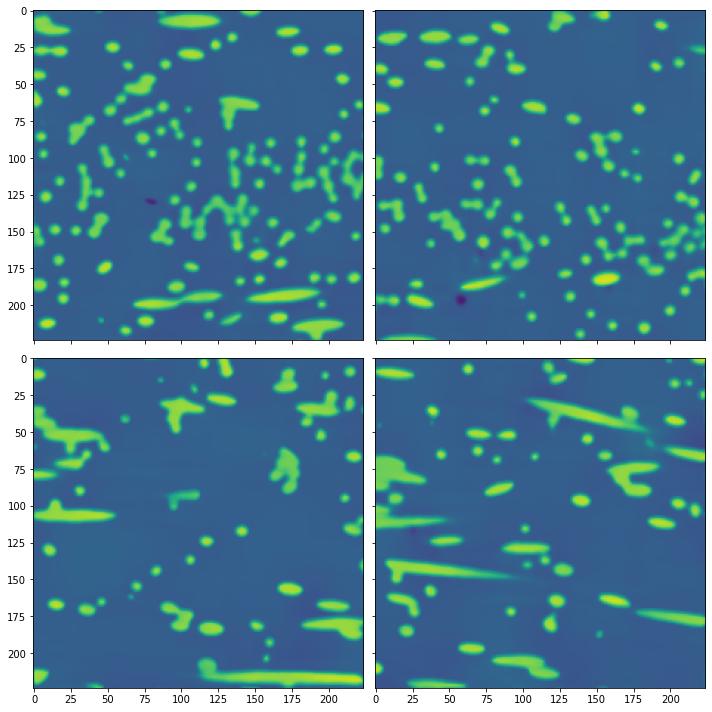

In [31]:
sz = 10
fig, axs = viz.tight_subplots(2, 2, sz, sz)
axs = [axs[0, 1], axs[1, 1], axs[0, 0], axs[1, 0]]
for idx, ax in zip(range(4), axs):
    slice_ = val[idx][0].reshape(224, 224)
    ax.imshow(slice_, vmin=0, vmax=1)

In [64]:
X = val.source_volume[:, :, 0]
crop_size = 224
n_steps = (
    int(np.ceil(X.shape[0] / 224)), 
    int(np.ceil(X.shape[1] / 224))
)

In [55]:
bins_starts = tuple(
    tuple(map(int, np.linspace(0, X.shape[dim] - crop_size, n_steps[dim])))
    for dim in (0, 1)
)
bins_starts

((0, 138, 276), (0, 138, 276))

In [56]:
import itertools

In [87]:
bins = []
for x0, y0 in itertools.product(bins_starts[0], bins_starts[1]):
    bins.append((
        (x0, x0 + crop_size), 
        (y0 ,y0 + crop_size)
    ))
bins

[((0, 224), (0, 224)),
 ((0, 224), (138, 362)),
 ((0, 224), (276, 500)),
 ((138, 362), (0, 224)),
 ((138, 362), (138, 362)),
 ((138, 362), (276, 500)),
 ((276, 500), (0, 224)),
 ((276, 500), (138, 362)),
 ((276, 500), (276, 500))]

In [88]:
crops = [
    X[x0:x1, y0:y1] 
    for (x0, x1), (y0, y1) in bins
]

In [118]:
X_sums = np.zeros_like(X).astype(np.int16)
X_counts = np.zeros_like(X)
for crop, ((x0, x1), (y0, y1)) in zip(crops, bins):
    X_sums[x0:x1, y0:y1] += crop
    X_counts[x0:x1, y0:y1] += np.ones_like(crop)
X_reconstructed = (X_sums / X_counts).astype(np.uint8)

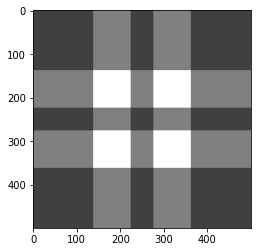

In [119]:
plt.imshow(X_counts, cmap=cm.gray, vmin=0, vmax=4)

In [120]:
from matplotlib import cm

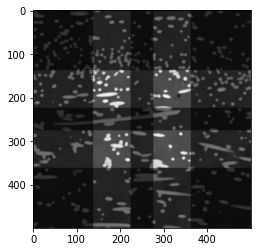

In [121]:
plt.imshow(X_sums, cmap=cm.gray)

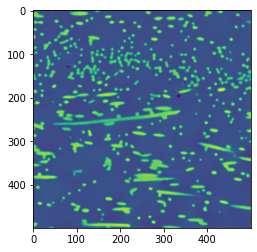

In [122]:
plt.imshow(X_reconstructed)

In [123]:
assert all((X == X_reconstructed).ravel())

## Validation

In [7]:
val_pred = np.load("val-pred-classes.npy")

# Examples

In [8]:
from skimage import data, segmentation
from skimage import filters
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_border(idx, generator, predictions):    
    img = generator[idx][0].reshape(224, 224)
    gt = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
    pred = predictions[idx]

    gt_mask_fiber = gt == labels.fiber
    gt_mask_hole = gt == labels.hole
    
    gt_edges_fiber = segmentation.find_boundaries(gt_mask_fiber)
    gt_edges_fiber = np.ma.masked_where(~gt_edges_fiber, gt_edges_fiber)

    gt_edges_hole = segmentation.find_boundaries(gt_mask_hole)
    gt_edges_hole = np.ma.masked_where(~gt_edges_hole, gt_edges_hole)
    
    pred_mask_fiber = pred == labels.fiber
    pred_mask_hole = pred == labels.hole
    
    pred_edges_fiber = segmentation.find_boundaries(pred_mask_fiber)
    pred_edges_fiber = np.ma.masked_where(~pred_edges_fiber, pred_edges_fiber)

    pred_edges_hole = segmentation.find_boundaries(pred_mask_hole)
    pred_edges_hole = np.ma.masked_where(~pred_edges_hole, pred_edges_hole)

    sz = 10
    fig, axs = plt.subplots(2, 2, figsize=(sz, sz), dpi=200)
    fig.tight_layout()
    for ax in axs.ravel():
        ax.axis('off')
    
    # upper left
    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title("Image")
    
    # upper right
    axs[0, 1].imshow(img, cmap='gray')
    axs[0, 1].imshow(gt_edges_fiber, cmap=ListedColormap(['blue']), interpolation=None)
    axs[0, 1].imshow(gt_edges_hole, cmap=ListedColormap(['yellow']), interpolation=None)
    axs[0, 1].set_title("Ground truth")
    
    # bottom left
    axs[1, 0].imshow(img, cmap='gray')
    axs[1, 0].imshow(pred_edges_fiber, cmap=ListedColormap(['red']), interpolation=None)
    axs[1, 0].imshow(pred_edges_hole, cmap=ListedColormap(['magenta']), interpolation=None)
    axs[1, 0].set_title("Prediction")
    
    # bottom right
    axs[1, 1].imshow(img, cmap='gray')
    axs[1, 1].imshow(gt_edges_fiber, cmap=ListedColormap(['blue']), interpolation=None)
    axs[1, 1].imshow(gt_edges_hole, cmap=ListedColormap(['yellow']), interpolation=None)
    axs[1, 1].imshow(pred_edges_fiber, cmap=ListedColormap(['red']), interpolation=None)
    axs[1, 1].imshow(pred_edges_hole, cmap=ListedColormap(['magenta']), interpolation=None)
    axs[1, 1].set_title("Ground truth X Prediction")
 
    
plot_border_val = functools.partial(plot_border, generator=val, predictions=val_pred)  

In [9]:
def plot_pred(generator, predictions, idx, label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    viz.show_slice(
        ax, 
        generator[idx][0].reshape(224, 224), 
        (~(predictions[idx] == label)).astype(int)
    )
    

def plot_label(generator, idx, label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    viz.show_slice(
        ax, 
        generator[idx][0].reshape(224, 224), 
        (~(generator[idx][1].reshape(224, 224, 3).argmax(axis=2) == label)).astype(int)
    )

In [13]:
# plot_train_label = functools.partial(plot_label, generator=train)
# plot_train_pred = functools.partial(plot_pred, generator=train, predictions=train_pred)

plot_val_label = functools.partial(plot_label, generator=val)
plot_val_pred = functools.partial(plot_pred, generator=val, predictions=val_pred)

# Find some bad segmentations

## Image accuracy

In [14]:
accuracies = []
for idx in range(len(val)):
    truth = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
    pred = val_pred[idx]

    accuracies.append(
        (truth == pred).sum() / (truth.shape[0] * truth.shape[1])
    )

In [15]:
accuracies_sort = np.argsort(accuracies)

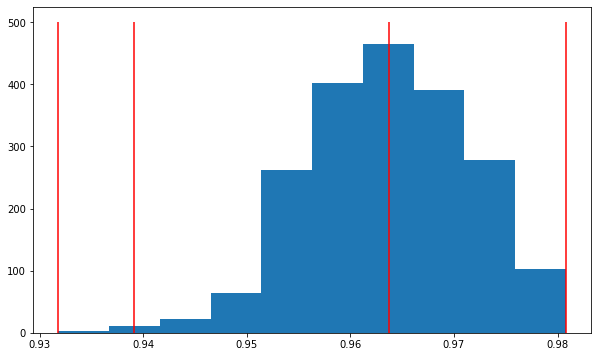

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(accuracies)
ax.vlines([accuracies[accuracies_sort[p]] for p in [0, 10, 1000, -1]], 0, 500, color='red')

## Cross entropy

In [21]:
val_pred_probas = np.load("val-pred-probas.npy")

In [22]:
losses = []
for idx in tqdm(range(len(val))):
    truth = val[idx][1].reshape(224, 224, 3).argmax().ravel()
    truth = val[idx][1].reshape(224, 224, 3).reshape(-1, 3)
    pred = val_pred_probas[idx].reshape(-1, 3)

    losses.append(met.log_loss(truth, pred))

In [23]:
losses_sort = np.argsort(losses)

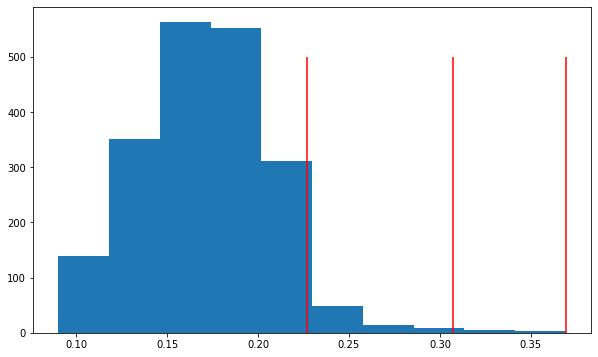

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(losses)
ax.vlines([losses[losses_sort[p]] for p in [-100, -10, -1]], 0, 500, color='red')

## Error blobs

In [10]:
idx = 0
generator = val
predictions = val_pred
img = generator[idx][0].reshape(224, 224)
gt = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
pred = predictions[idx]

In [11]:
import skimage

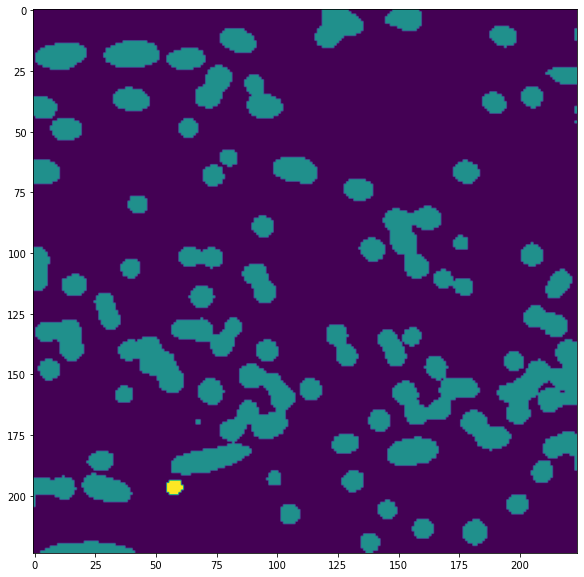

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(gt)

blobs, n_blobs = skimage.measure.label(gt, connectivity=2, return_num=True, background=0)

In [14]:
n_blobs

75

In [15]:
blob_stack = [(blobs == i).reshape(*blobs.shape, 1) for i in range(n_blobs + 1)]
blob_stack = np.concatenate(blob_stack, axis=2)

In [ ]:
blob